# Exploratory Data Analysis (EDA) for Movie Overview Dataset

We perform EDA on a cleaned movie dataset (2015-2023) to uncover patterns and insights. Key steps include text preprocessing of movie overviews, visualization of language distribution, analysis of overview lengths, extraction of common words, and creation of word clouds. It further explores numeric feature correlations, relationships between ratings and popularity, and genre-based variations in overview lengths.

In [1]:
# Import necessary libraries
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from collections import Counter
from nltk.util import ngrams
import unidecode
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")


In [2]:
# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rawan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rawan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Load the dataset
df = pd.read_csv('data/cleaned_movies_2015_2023_genres.csv')

In [4]:
# Load stopwords for English and German
stop_words = set(stopwords.words('english')).union(set(stopwords.words('german')))
lemmatizer = WordNetLemmatizer()

In [5]:
# Function for text preprocessing

def preprocess_text(text):
    # Remove HTML tags, URLs, numbers, and special characters
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    
    # Remove accents/diacritics
    text = unidecode.unidecode(text)
    
    # Lowercase and strip spaces
    text = text.lower().strip()
    
    # Expand contractions (optional, for English text)
    contractions_dict = {
        "can't": "cannot", "won't": "will not", "don't": "do not", "doesn't": "does not", 
        "i'm": "i am", "it's": "it is", "i'll": "i will", "you're": "you are", "he's": "he is"
    }
    for contraction, expanded in contractions_dict.items():
        text = text.replace(contraction, expanded)

    # Handle negations (optional)
    text = re.sub(r'\bnot\b (\w+)', r'not_\1', text)
    
    # Tokenization, lemmatization, stopword removal, and stemming
    words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    
    # Remove extra spaces
    text = ' '.join(words)
    
    return text

In [6]:
# Apply preprocessing to the 'overview' column
df['cleaned_overview'] = df['overview'].dropna().apply(preprocess_text)


In [7]:
# Save the preprocessed data
df.to_csv('data/movies_2015_2023_preprocessed_genre.csv', index=False)

### EDA - Exploratory Data Analysis ###

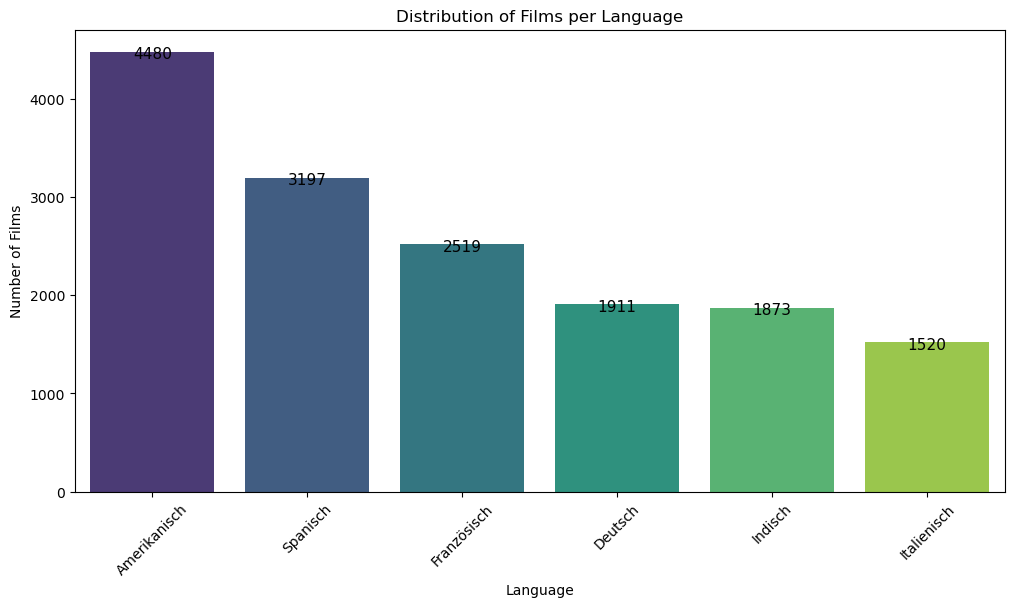

In [8]:
# 1. Language Distribution (With Improved Visuals)
language_counts = df['language'].value_counts()

plt.figure(figsize=(12, 6))
sorted_counts = language_counts.sort_values(ascending=False)
sns.barplot(x=sorted_counts.index, y=sorted_counts.values, palette='viridis')
plt.title('Distribution of Films per Language')
plt.xlabel('Language')
plt.ylabel('Number of Films')
plt.xticks(rotation=45)

# Add data labels
for i, count in enumerate(sorted_counts.values):
    plt.text(i, count + 50, str(count), ha='center', va='top', fontsize=11)

plt.show()


Overview length summary:
                count       mean        std  min   25%   50%   75%    max
language                                                                
Amerikanisch  4480.0  23.947098  12.172116  2.0  15.0  21.0  30.0   94.0
Deutsch       1911.0  31.468341  19.776048  2.0  17.0  26.0  42.0  104.0
Französisch   2519.0  26.586344  14.867150  2.0  16.0  23.0  35.0   95.0
Indisch       1873.0  22.904431  14.812465  0.0  14.0  18.0  27.0   96.0
Italienisch   1520.0  27.302632  18.411842  1.0  14.0  22.0  36.0   93.0
Spanisch      3197.0  22.879262  14.042838  2.0  13.0  19.0  29.0  107.0


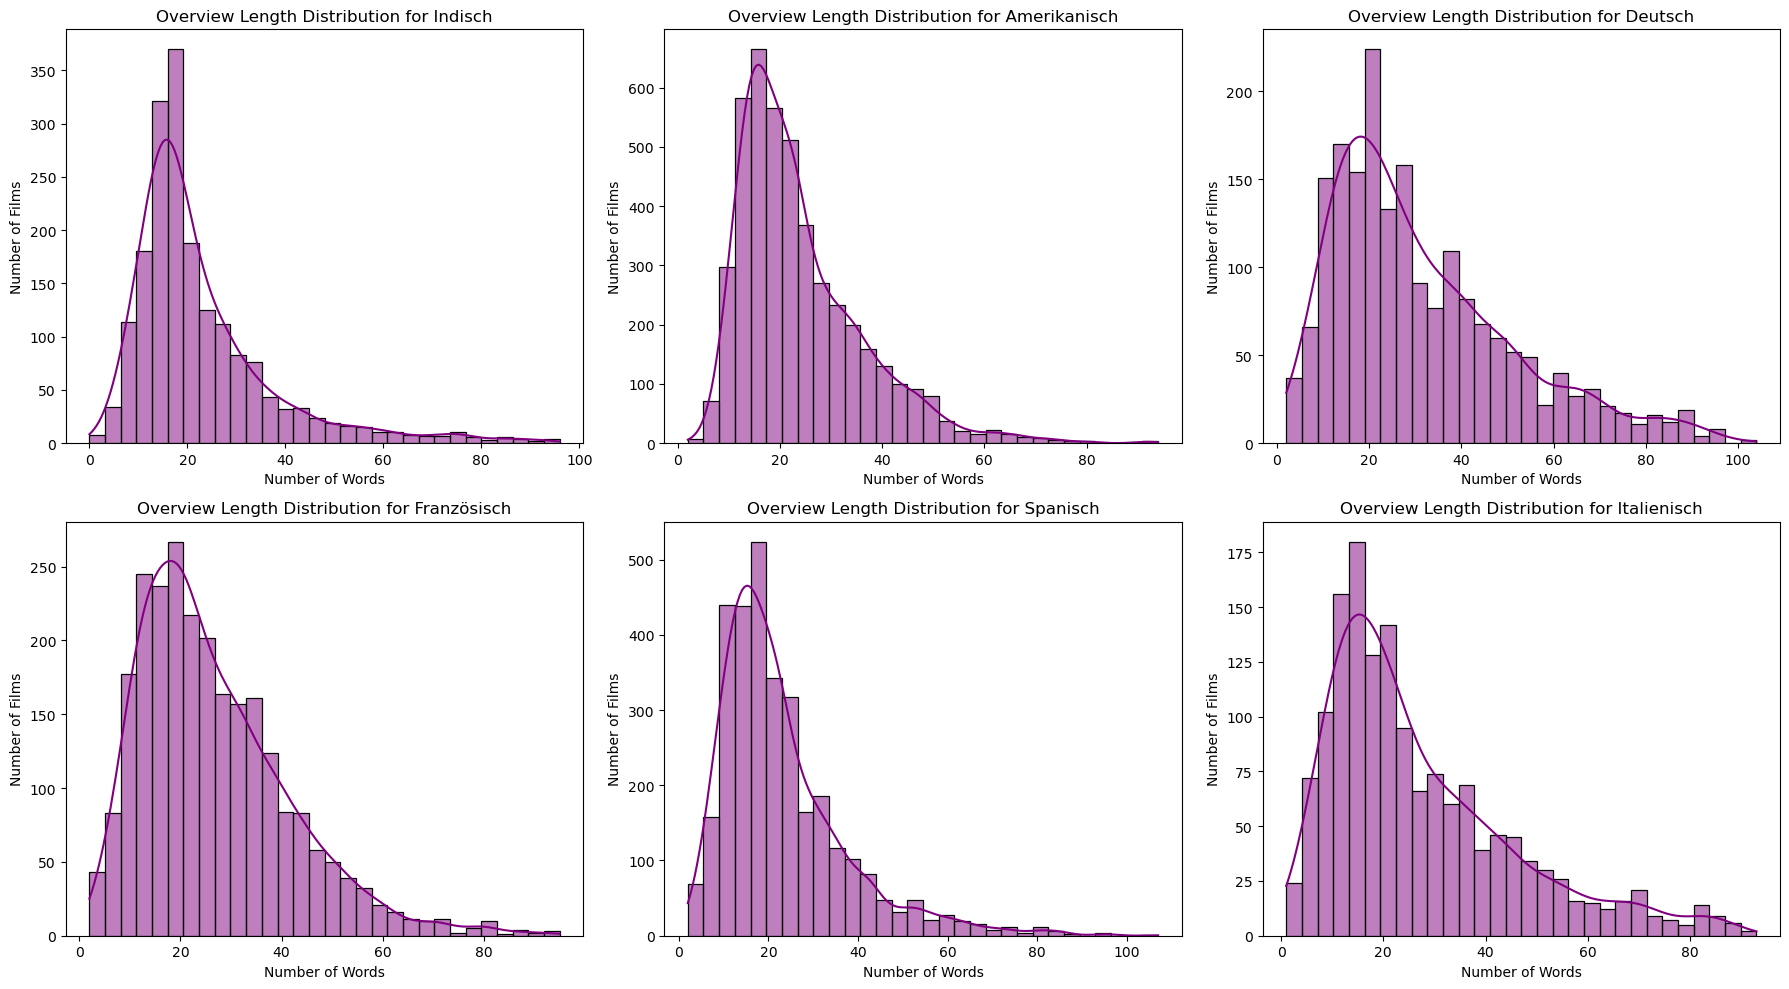

In [9]:
# Ensure all entries in 'cleaned_overview' are strings and handle NaN values
df['cleaned_overview'] = df['cleaned_overview'].fillna('').astype(str)

# 2. Overview Length Distribution per Language
# Calculate overview length
df['overview_length'] = df['cleaned_overview'].apply(lambda x: len(x.split()))

# Display summary statistics for overview length
overview_length_summary = df.groupby('language')['overview_length'].describe()
print("Overview length summary:\n", overview_length_summary)

# Plot distributions using a grid layout for comparison
languages = df['language'].unique()
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, language in enumerate(languages):
    sns.histplot(df[df['language'] == language]['overview_length'], bins=30, kde=True, ax=axes[i], color='purple')
    axes[i].set_title(f'Overview Length Distribution for {language}')
    axes[i].set_xlabel('Number of Words')
    axes[i].set_ylabel('Number of Films')

plt.tight_layout()
plt.show()


In [10]:

# 3. Most Common Words and N-Grams
# Extract all words and bigrams
all_words = []
all_bigrams = []

for text in df['cleaned_overview']:
    all_words.extend(text.split())
    all_bigrams.extend(ngrams(text.split(), 2))

# Most common words
word_counts = Counter(all_words)
print("Most common words:", word_counts.most_common(10))

# Most common bigrams
bigram_counts = Counter(all_bigrams)
print("Most common bigrams:", bigram_counts.most_common(10))

Most common words: [('life', 4121), ('love', 2623), ('one', 2289), ('young', 2190), ('family', 2097), ('find', 1995), ('friend', 1980), ('two', 1881), ('new', 1722), ('year', 1718)]
Most common bigrams: [(('best', 'friend'), 452), (('fall', 'love'), 379), (('young', 'woman'), 369), (('year', 'old'), 309), (('one', 'day'), 296), (('high', 'school'), 253), (('love', 'story'), 190), (('new', 'york'), 183), (('small', 'town'), 175), (('first', 'time'), 141)]


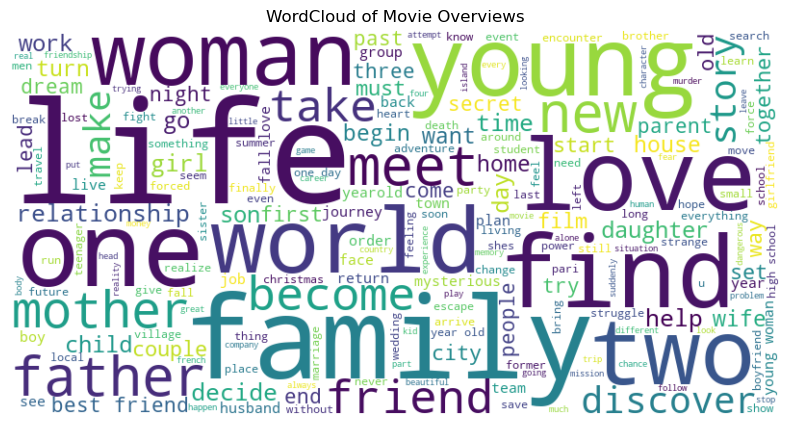

In [11]:
# 4. WordCloud for Overall Overviews
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud of Movie Overviews')
plt.show()

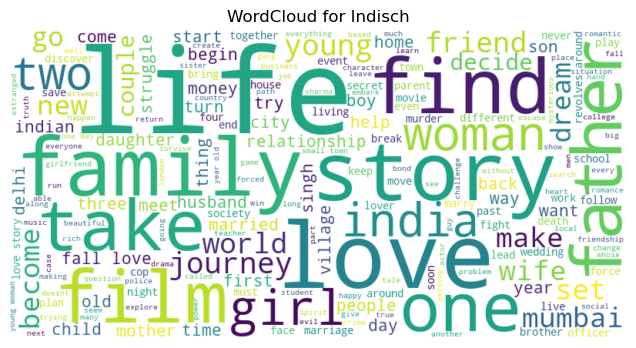

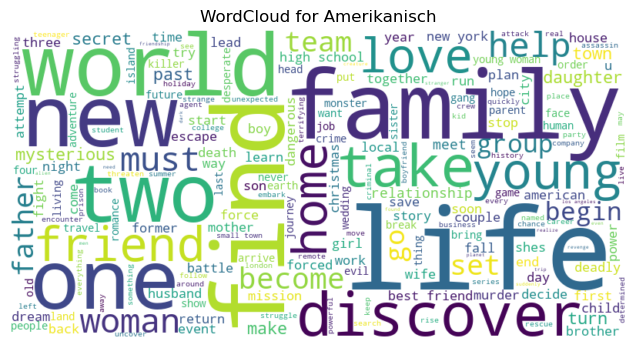

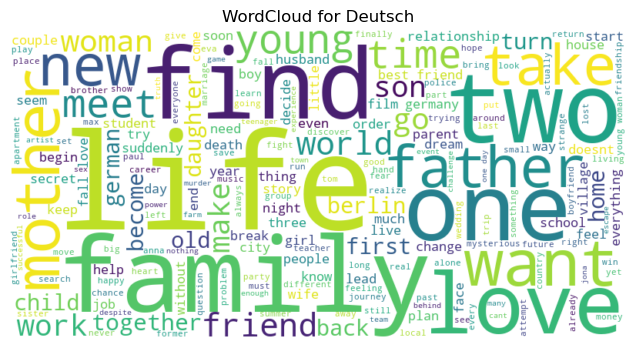

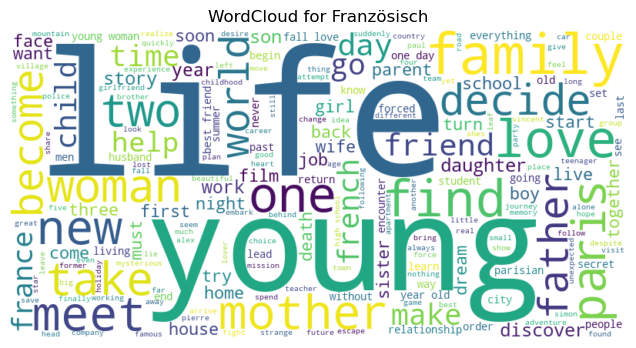

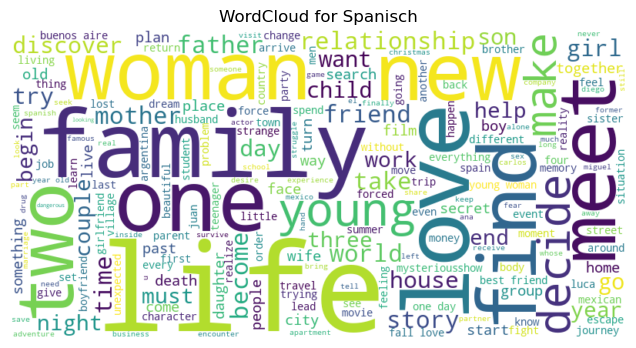

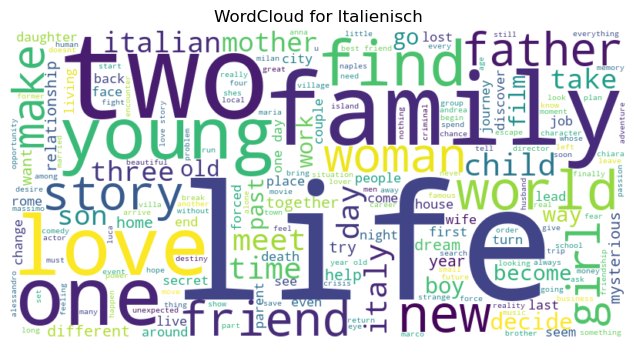

In [12]:
# 5. WordCloud for Each Language
def create_wordcloud(language_data, language_name):
    text = ' '.join(language_data.dropna())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud for {language_name}')
    plt.show()

for language in languages:
    language_data = df[df['language'] == language]['overview']
    create_wordcloud(language_data, language)

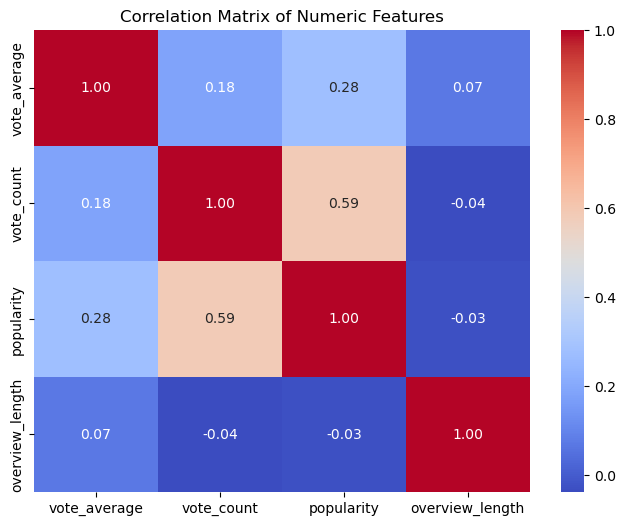

In [13]:
# 6. Correlation Matrix for Numeric Features
correlation_matrix = df[['vote_average', 'vote_count', 'popularity', 'overview_length']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Features')
plt.show()


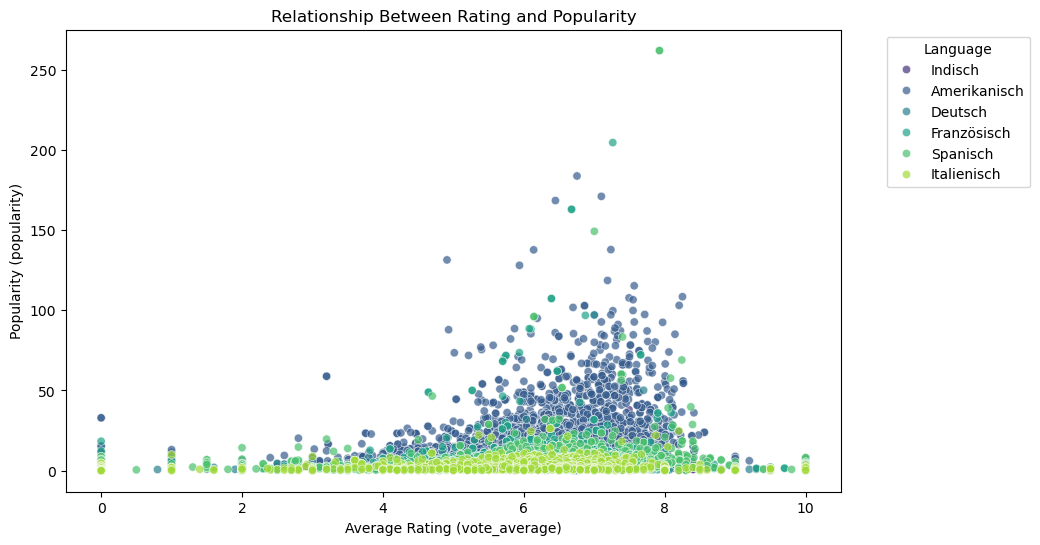

In [14]:
# 7. Relationship Between Rating and Popularity
plt.figure(figsize=(10, 6))
sns.scatterplot(x='vote_average', y='popularity', data=df, hue='language', palette='viridis', alpha=0.7)
plt.title('Relationship Between Rating and Popularity')
plt.xlabel('Average Rating (vote_average)')
plt.ylabel('Popularity (popularity)')
plt.legend(title='Language', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [15]:
# 9. Top Words per Language
def get_top_words_by_language(df, language, top_n=10):
    words = []
    for text in df[df['language'] == language]['cleaned_overview']:
        words.extend(text.split())
    word_counts = Counter(words)
    return word_counts.most_common(top_n)

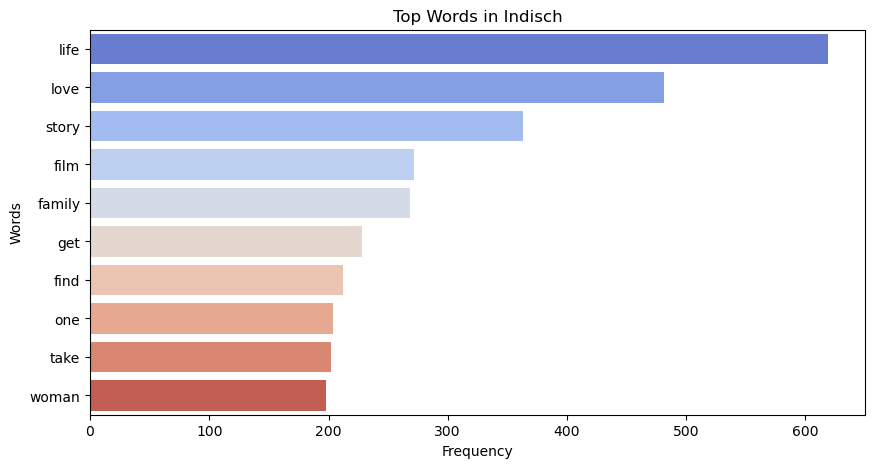

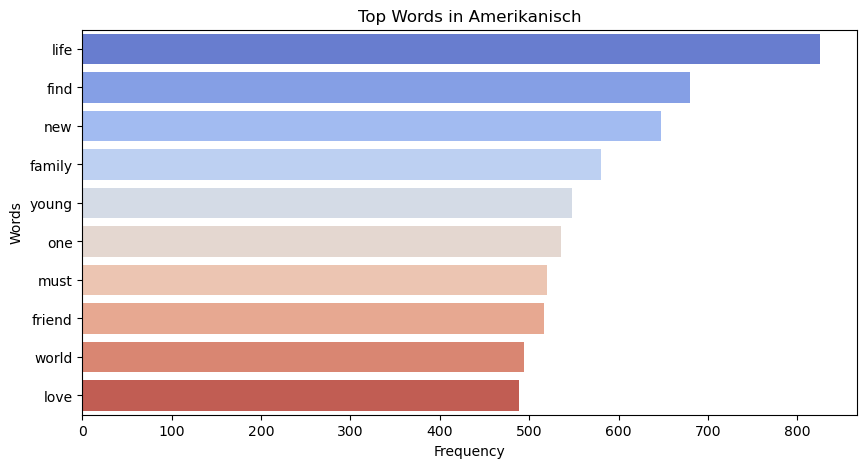

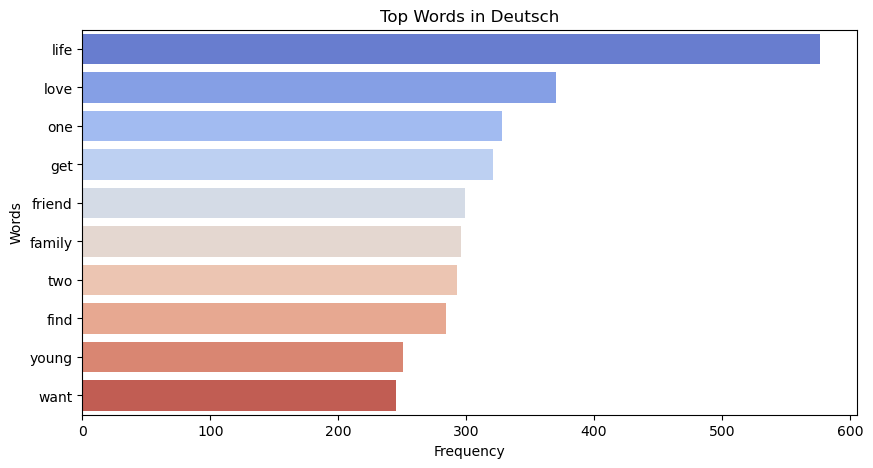

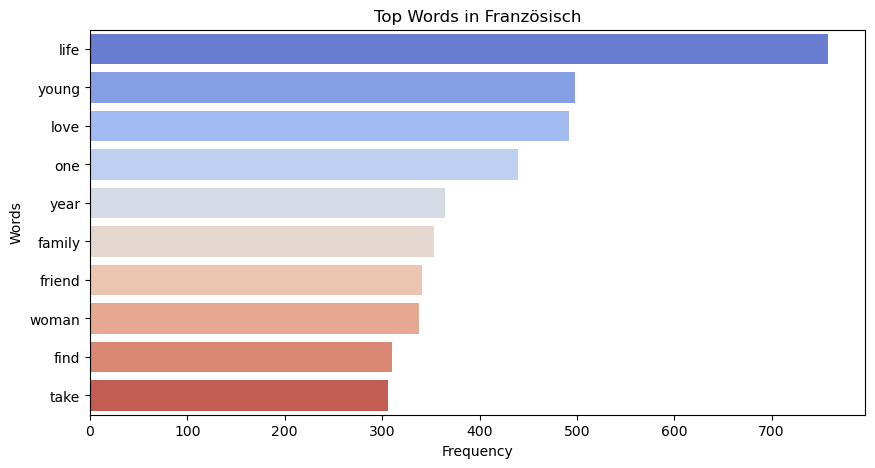

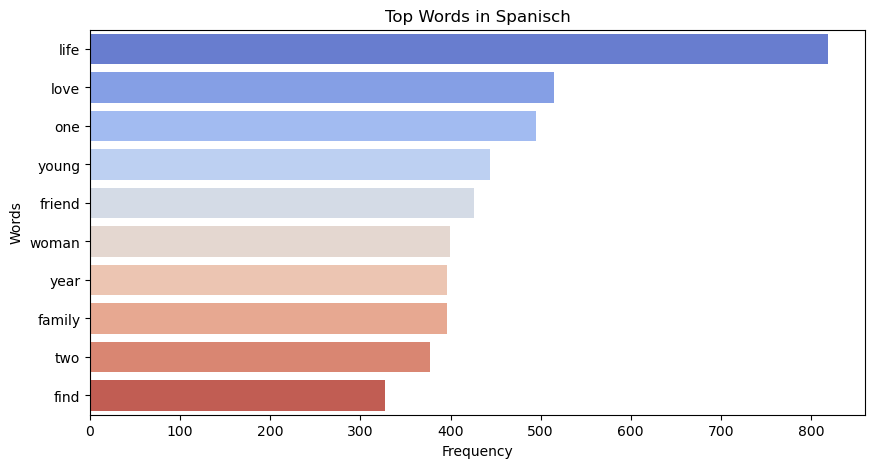

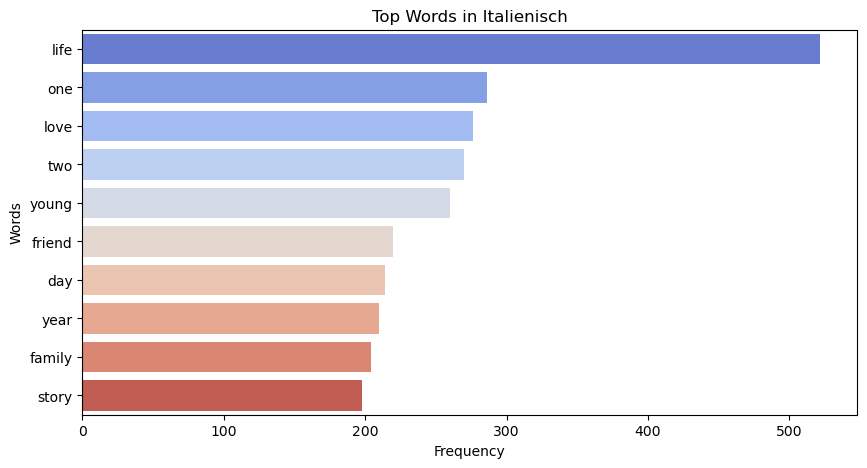

In [16]:
# Generate and visualize top words for each language
for language in languages:
    top_words = get_top_words_by_language(df, language)
    words, counts = zip(*top_words)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(counts), y=list(words), palette='coolwarm')
    plt.title(f'Top Words in {language}')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.show()

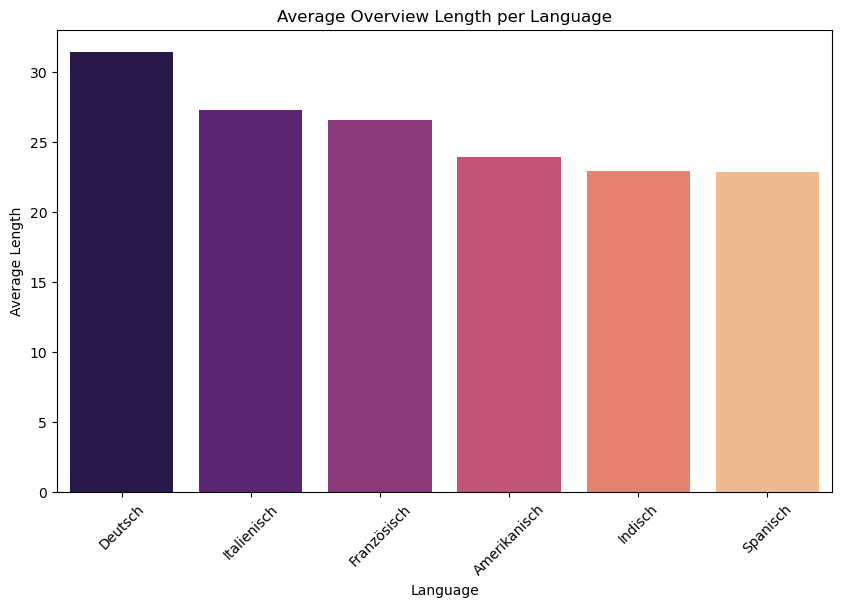

In [17]:
# 10. Average Overview Length per Language
average_length_by_language = df.groupby('language')['overview_length'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=average_length_by_language.index, y=average_length_by_language.values, palette='magma')
plt.title('Average Overview Length per Language')
plt.xlabel('Language')
plt.ylabel('Average Length')
plt.xticks(rotation=45)
plt.show()

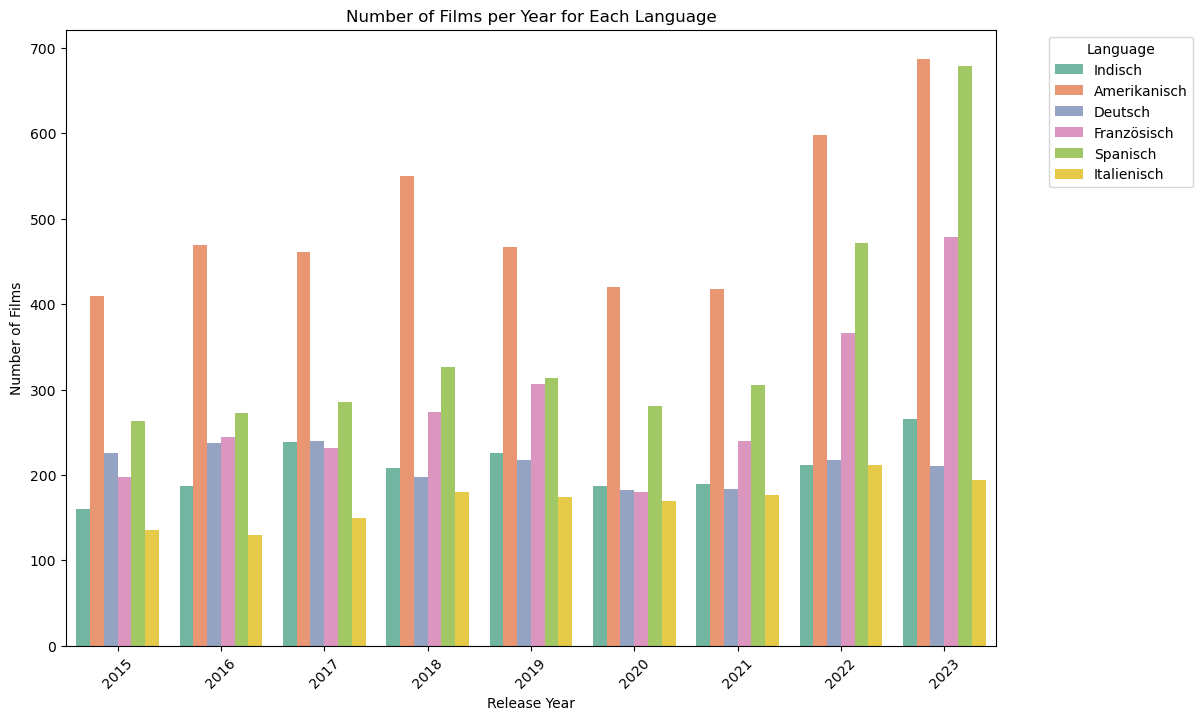

In [18]:
# 11. Number of Films per Year and Language
plt.figure(figsize=(12, 8))
sns.countplot(x='release_year', hue='language', data=df, palette='Set2')
plt.title('Number of Films per Year for Each Language')
plt.xlabel('Release Year')
plt.ylabel('Number of Films')
plt.xticks(rotation=45)
plt.legend(title='Language', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

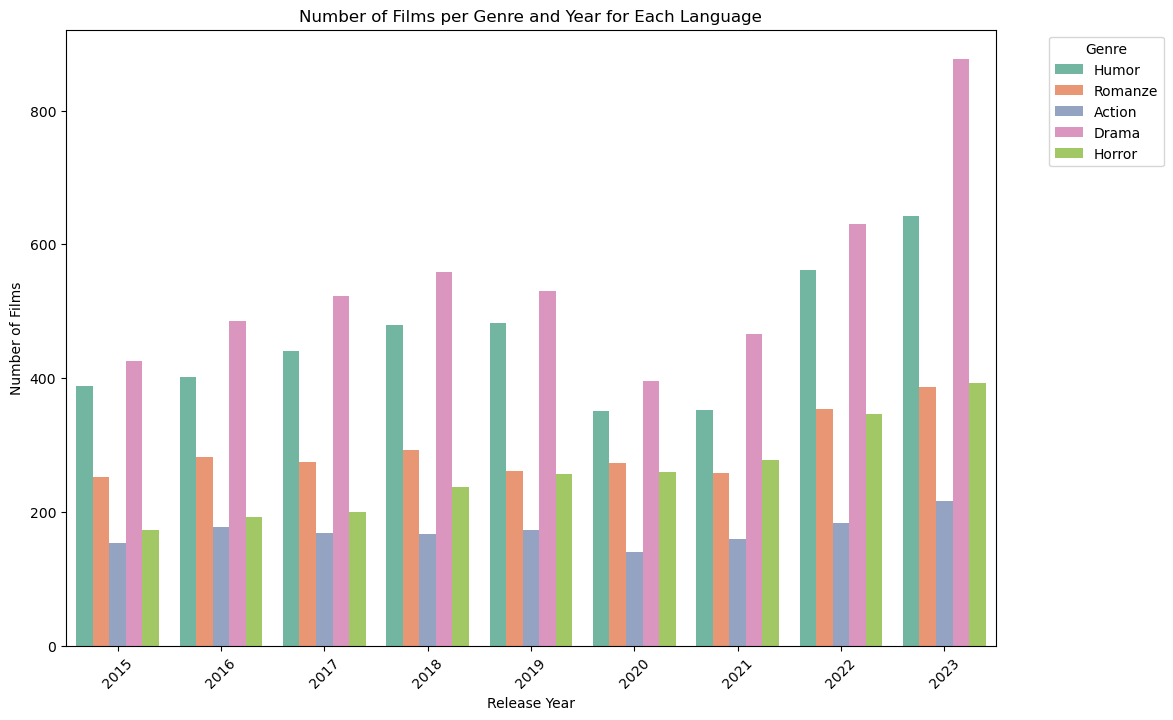

In [19]:
# 12. Number of Films per Genre and Year for Each Language
plt.figure(figsize=(12, 8))

# Creating the count plot for genre per year and language
sns.countplot(x='release_year', hue='genre', data=df, palette='Set2')

# Adding title and labels
plt.title('Number of Films per Genre and Year for Each Language')
plt.xlabel('Release Year')
plt.ylabel('Number of Films')

# Rotating the x-axis labels for better readability
plt.xticks(rotation=45)

# Adding legend for genres
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')

# Displaying the plot
plt.show()

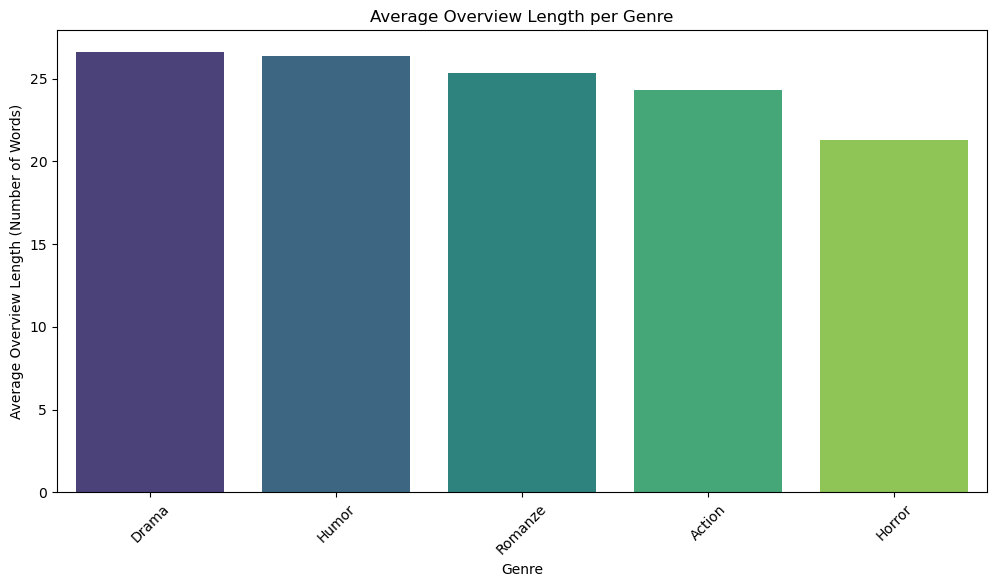

In [20]:
average_length_by_genre = df.groupby('genre')['overview_length'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=average_length_by_genre.index, y=average_length_by_genre.values, palette='viridis')
plt.title('Average Overview Length per Genre')
plt.xlabel('Genre')
plt.ylabel('Average Overview Length (Number of Words)')
plt.xticks(rotation=45)
plt.show()

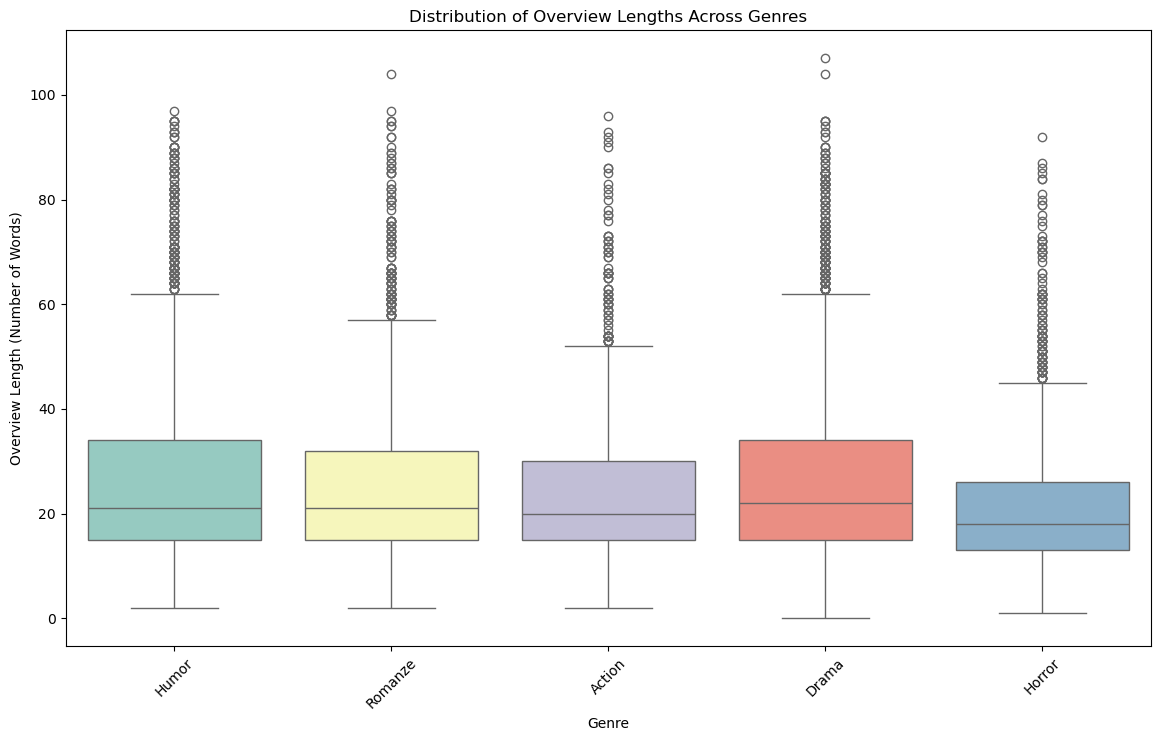

In [21]:
# 9. Box Plot of Overview Lengths Across Genres
plt.figure(figsize=(14, 8))
sns.boxplot(data=df, x='genre', y='overview_length', palette='Set3')
plt.title('Distribution of Overview Lengths Across Genres')
plt.xlabel('Genre')
plt.ylabel('Overview Length (Number of Words)')
plt.xticks(rotation=45)
plt.show()